- Some stuff from
https://github.com/tdeboissiere/DeepLearningImplementations/blob/master/WassersteinGAN/src/model/train_WGAN.py

In [1]:
%run 'Lib.ipynb'

In [2]:
OUT_DIR = 'out_8e'
if not os.path.isdir(OUT_DIR): os.makedirs(OUT_DIR)

In [3]:
# use GPU 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
from collections import defaultdict

import keras.backend as K
from keras.datasets import mnist
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.utils.generic_utils import Progbar

Using TensorFlow backend.


In [5]:
Z_SIZE = 200

# batch and latent size taken from the paper
EPOCHS = 50
BATCH_SIZE = 64

# how many times to train D per each G(D) update
# 5 is suggested in https://arxiv.org/pdf/1701.07875.pdf
D_TRAIN_ITERATIONS = 5

# D weight clipping per https://arxiv.org/pdf/1701.07875.pdf
D_WEIGHTS_LOWER_BOUND = -0.01
D_WEIGHTS_UPPER_BOUND = 0.01

# learning rate, per https://arxiv.org/pdf/1701.07875.pdf 
RMSPROP_LR = 0.00005

In [6]:
np.random.seed(777)

In [7]:
K.set_image_dim_ordering('tf')

In [8]:
def create_D():
    input_image = Input(shape=(28, 28, 1), name='input_image')

    x = Conv2D(32, (3, 3), padding='same', name='conv_1')(input_image)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding='same', name='conv_2')(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv_3')(x)
    x = MaxPool2D(pool_size=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), padding='same', name='coonv_4')(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    features = Flatten()(x)

    output_is_fake = Dense(
        1, activation='linear', name='output_is_fake')(features)

    return Model(inputs=[input_image], outputs=[output_is_fake], name='D')

In [9]:
def create_G(Z_SIZE=Z_SIZE):
    # latent var
    input_z = Input(shape=(Z_SIZE, ), name='input_z')

    # cnn part

    x = Dense(512 * 7 * 7)(input_z)
    x = LeakyReLU()(x)
    x = Reshape((7, 7, 512))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (5, 5), padding='same')(x)
    x = LeakyReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (5, 5), padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, (2, 2), padding='same', activation='tanh', name='output_generated_image')(x)

    return Model(inputs=[input_z], outputs=[x], name='G')

In [10]:
def wasserstein(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [11]:
D = create_D()
D.compile(optimizer=RMSprop(lr=RMSPROP_LR), loss=[wasserstein])

In [12]:
input_z = Input(shape=(Z_SIZE, ), name='input_z_')

In [13]:
G = create_G()
G.compile(loss='mse', optimizer=RMSprop(lr=RMSPROP_LR))

In [14]:
# create combined D(G) model
output_is_fake = D(G(inputs=[input_z]))
combined = Model(inputs=[input_z], outputs=[output_is_fake])
combined.compile(optimizer=RMSprop(lr=RMSPROP_LR), loss=[wasserstein])

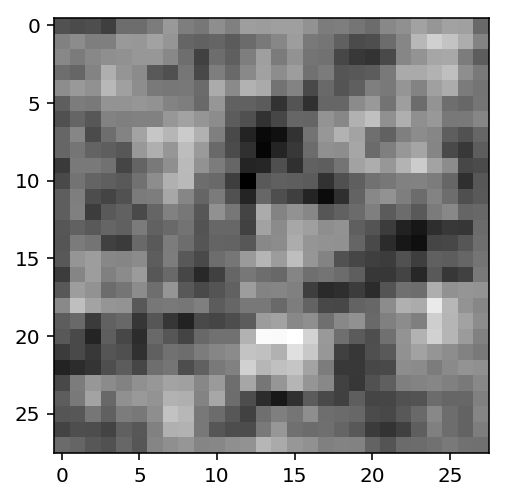

In [15]:
# try generating image
z = np.random.randn(Z_SIZE).reshape(1, Z_SIZE)
img = G.predict([z])
plt.imshow(img.reshape((28, 28)), cmap=plt.cm.gray)

In [16]:
# get our mnist data, and force it to be of shape (..., 28, 28, 1) with
# range [-1., 1.]
(X_train, _), (X_test, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=3)

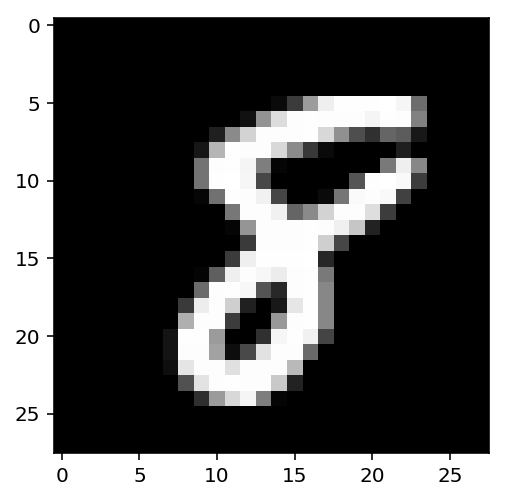

In [17]:
plt.imshow(X_train[777].reshape((28, 28)), cmap=plt.cm.gray)

In [18]:
train_num_samples, test_num_samples = X_train.shape[0], X_test.shape[0]

In [ ]:
def save_generated_samples(n):

    # new batch of z's
    zz = np.random.normal(0., 1., (100, Z_SIZE))

    generated_images = G.predict([zz])

    rr = []
    for c in range(10):
        rr.append(np.concatenate(generated_images[c * 10:(1 + c) * 10]).reshape(280, 28))
    img = np.hstack(rr)

    plt.imsave(OUT_DIR + '/generated@%d.png'%n, img, cmap=plt.cm.gray)

In [ ]:
g_it = 0

for epoch in range(EPOCHS):

    print('\nEpoch {} / {}'.format(epoch + 1, EPOCHS))

    batches_num = int(train_num_samples / BATCH_SIZE)
    progress_bar = Progbar(target=batches_num)

    epoch_D_losses_real = []
    epoch_D_losses_gen = []

    for batch_i in range(batches_num):

        if len(epoch_D_losses_real) > 0:
            progress_bar.update(
                batch_i,
                values=[
                        ('D_loss', -np.mean(epoch_D_losses_real[:])  - np.mean(epoch_D_losses_gen[:])),
                        ('D_loss_real', -np.mean(epoch_D_losses_real[:])),
                        ('D_loss_gen', np.mean(epoch_D_losses_gen[:])),
                        ('DG_loss', -DG_loss)
                ]
            )
        else:
            progress_bar.update(batch_i)
            
        # 1: train D on real+generated images
        
        # unfreeze D
        D.trainable = True
        
        d_iterations = D_TRAIN_ITERATIONS
        
        # pick number of D train iterations
        if g_it < 25 or g_it % 500 == 0:
            d_iterations = 100
        
        for d_it in range(d_iterations):

            # create batches of images and labels
            real_images = X_train[batch_i * BATCH_SIZE:(batch_i + 1) * BATCH_SIZE]

            # new batch of z's
            zz = np.random.normal(0., 1., (BATCH_SIZE, Z_SIZE))
            
            # batch of generated images
            generated_images = G.predict([zz])
            
            # clip D weights

            for l in D.layers:
                weights = l.get_weights()
                weights = [np.clip(w, D_WEIGHTS_LOWER_BOUND, D_WEIGHTS_UPPER_BOUND) for w in weights]
                l.set_weights(weights)
            
            # train D on real
            D_loss_real = D.train_on_batch(real_images, -np.ones([BATCH_SIZE]))
            epoch_D_losses_real.append(D_loss_real)
            
            # train G on generated
            D_loss_gen = D.train_on_batch(generated_images, np.ones([BATCH_SIZE]))
            epoch_D_losses_gen.append(D_loss_gen)

        
        # 2: train D(G) (only G is trainable)
                
        # freeze D
        D.trainable = False
        
        DG_loss = combined.train_on_batch(
            [np.random.normal(0., 1.,  (BATCH_SIZE, Z_SIZE))], [-np.ones(BATCH_SIZE)]
        ) # all non-fake 
        
        # unfreeze D
        D.trainable = True
        
        if (g_it % 250 == 0):
            save_generated_samples(g_it)
        
        g_it += 1


Epoch 1 / 50
936/937 [============================>.] - ETA: 0s - D_loss: 1.1060 - D_loss_real: 382.3305 - D_loss_gen: 381.2245 - DG_loss: 365.9005
Epoch 23 / 50
936/937 [============================>.] - ETA: 0s - D_loss: 1.4853 - D_loss_real: 381.6798 - D_loss_gen: 380.1945 - DG_loss: 365.1466
Epoch 24 / 50
936/937 [============================>.] - ETA: 0s - D_loss: 1.9678 - D_loss_real: 378.5526 - D_loss_gen: 376.5848 - DG_loss: 363.0572
Epoch 25 / 50
936/937 [============================>.] - ETA: 0s - D_loss: 2.5914 - D_loss_real: 374.8673 - D_loss_gen: 372.2759 - DG_loss: 360.6996
Epoch 26 / 50
936/937 [============================>.] - ETA: 0s - D_loss: 2.5295 - D_loss_real: 374.2844 - D_loss_gen: 371.7549 - DG_loss: 358.2811
Epoch 27 / 50
936/937 [============================>.] - ETA: 0s - D_loss: 2.7184 - D_loss_real: 375.1380 - D_loss_gen: 372.4196 - DG_loss: 357.9604
Epoch 28 / 50
936/937 [============================>.] - ETA: 0s - D_loss: 2.7711 - D_loss_real: 374.2345 

In [ ]:
# save_generated_samples(0)